In [1]:
import numpy as np
import wfdb
import os
import matplotlib.pyplot as plt
import pandas as pd
import glob
import math
from sklearn import preprocessing
import scipy
from scipy.signal import butter, filtfilt, resample
from sklearn.metrics import confusion_matrix 
from keras.layers import Layer, Lambda, Input, Dense, Dropout,BatchNormalization,Layer,Conv1D, Activation
from keras.layers import AveragePooling1D, UpSampling1D, Flatten, Reshape, MaxPooling1D
from keras.layers import Conv2D, UpSampling2D, MaxPooling2D
from keras.models import Model, Sequential
from keras.losses import mean_squared_error, binary_crossentropy
from keras import optimizers
from keras.optimizers import Adam, SGD
from sklearn.model_selection import train_test_split
from keras import backend as K
import collections
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import accuracy_score
from time import time
from sklearn.preprocessing import MinMaxScaler
import joblib

from sklearn.manifold import TSNE
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

def plot_confusion_matrix(y_true, y_pred, title, Y_lbl, cmap = plt.cm.Blues):
    classes = np.unique(Y_lbl)
    labels = range(len(classes))

    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm2 = np.round(cm/cm.sum(axis=1)[:,None]*100, decimals=1)
    plt.figure(figsize=(6, 6))
    plt.imshow(cm2, interpolation='nearest', cmap=cmap, vmin=0, vmax=100)
    plt.title(title+" confusion matrix", fontsize=15)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=10)
    plt.yticks(tick_marks, classes, fontsize=10)
    
    thresh = cm2.max() / 2.
    for i, j in itertools.product(range(cm2.shape[0]), range(cm2.shape[1])):
        plt.text(j, i, cm2[i, j],
                 horizontalalignment="center",
                 color="white" if cm2[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=10)
    plt.xlabel('Predicted label', fontsize=10)

    plt.show()
def evaluation(confusion_matrix):
    TP = np.diag(confusion_matrix)
    FP = np.sum(confusion_matrix, axis=0) - TP 
    FN = np.sum(confusion_matrix, axis=1) - TP
    TN = []

    for i in range(confusion_matrix.shape[1]):
        temp = np.delete(confusion_matrix, i, 0)    # delete ith row\n",
        temp = np.delete(temp, i, 1)  # delete ith column\
        TN.append(sum(sum(temp)))

        accuracy = np.round((TP+TN)/(TP+TN+FP+FN)*100, 2)
        specificity = np.round(TN/(TN+FP)*100,2)
        recall = np.round(TP/(TP+FN)*100, 2)
        
        df_column_names = ['Accuracy (%)','Specificity (%)','Sensit/Recall (%)']
        df_row_names = ['F','N','S','V']
        evaluation = pd.DataFrame(np.concatenate((accuracy.reshape(-1,1),
                                                  specificity.reshape(-1,1),
                                                  recall.reshape(-1,1)),axis=1),
                                                  index=df_row_names, columns=df_column_names)
        return evaluation
#Find AAMI classes

def which_class(x):
    if np.isin(x,N): return 'N'
    elif np.isin(x,S): return 'S'
    elif np.isin(x,V): return 'V'
    elif np.isin(x,F): return 'F'
    else: return 'N'

#definition of AAMI classes
N = ['.','N','L','R','e','j','n'];
S = ['A','a','J','S'];
V = ['V','E','r'];
F = ['F'];


In [2]:
complete_data = pd.DataFrame()

half_qrs = 210 #Single beat segmentation -> initial beat length: 420pt
pts = 320 #Triple beat segmentation -> beat length: 320pt
count = 0
maximum = 75
database = 'incartdb'
sampling_rate = 257
lead = []
# Define the cutoff frequency
cutoff_freq = 100  # Hz
# Define the filter order
filter_order = 4
# Calculate the normalized cutoff frequency
nyquist_freq = 0.5 * 360  # The Nyquist frequency is half the sampling rate
normalized_cutoff_freq = cutoff_freq / nyquist_freq
# Define the number of samples to use for padding
padlen = 3
#Beat selection from Physionet beats annotation guidlines
good_beats = ['N', 'L', 'R', 'B', 'A', 'a', 'J', 'S', 'V', 'r','F', 'e', 'j', 'n', 'E']

for filename in os.listdir(database):
    if count < maximum:
        if filename.endswith(".dat"):
            ann = wfdb.rdann(database + '/' + filename.strip('.dat'), 'atr')
            record = wfdb.rdsamp(database + '/' + filename.strip('.dat'))
            record_num = filename.strip('.dat')
            
            #Signals
            data = record[0]
            info = record[1]
            lead = info["sig_name"]
            resampling_factor = 360 / sampling_rate
            resampled_signal = scipy.signal.resample(data, int(len(data) * resampling_factor))

            # Design the filter coefficients
            b, a = butter(filter_order, normalized_cutoff_freq, btype='lowpass')

            # Apply the filter to the resampled ECG signal
            filtered_signal = filtfilt(b, a, resampled_signal, padlen=padlen)

            signals1, signals2, classes, signals3 = [], [], [], []

            data = filtered_signal[:,[1,6]]
            #data = data[:,[1,6]]

            #Beat extraction
            for it, beat in enumerate(ann.symbol):
                if it>0:
                    if beat in good_beats:
                        
                        new_annotation = int(ann.sample[it] * (360 / sampling_rate))
                        new_annotation_prev = int(ann.sample[it-1] * (360 / sampling_rate))
                        
                        #Single beat extraction
                        sta1 = new_annotation - half_qrs
                        end1 = new_annotation + half_qrs
                        qrs1 = data[sta1 : end1, :]

                        
                        #Triple beat extraction
                        sta2 = math.floor((new_annotation + new_annotation_prev)/2)
                        end2 = sta2 + pts
                        qrs2 = data[sta2 : end2, :]
                        
                        #Avoid problems at the edges
                        if len(qrs1) != 2 * half_qrs: continue
                        if end2 > len(data[:,0]): continue

                        curr_beat1 = qrs1.reshape(half_qrs*2,2)
                        curr_beat2 = qrs2.reshape(pts,2)
                        signals1.append(curr_beat1)
                        signals2.append(curr_beat2)
                        classes.append(beat)

            #Triple beat arrangement
            for i in range(1,len(signals2)-1):
                temp = np.hstack((signals2[i-1],signals2[i],signals2[i+1]))
                signals3.append(temp)
                temp=0
                
            #Single and triple beat consistency
            signals1.pop(0)
            signals1.pop(-1)
            classes.pop(0)
            classes.pop(-1)
            
            
            #Obtained data 
            frame = pd.DataFrame({'beat' : signals1,
                                '3beat' : signals3,
                                'label' : classes,
                                'record' : record_num})

            complete_data = complete_data.append(frame)
            count = count + 1

In [3]:

#Single beat
df = complete_data
test = df['beat'].values
testX = np.vstack(test).reshape(test.shape[0],half_qrs*2,2)
testX_1beat = np.zeros((testX.shape[0], 320, 2))
for i in range(testX_1beat.shape[0]):
    sta = np.random.choice(range(0,100))
    end = sta + 320
    testX_1beat[i,:,:] = testX[i, sta:end, :]
#mean_vals = np.mean(testX_1beat, axis=1)[:, np.newaxis]  # shape (n_samples, 1)
#testX_1beat = testX_1beat - mean_vals

#Triple beat
beats_3 = df['3beat'].values
testX_3beat = np.vstack(beats_3).reshape(beats_3.shape[0],pts,6) #
mean_vals = np.mean(testX_3beat, axis=1)[:, np.newaxis]  # shape (n_samples, 1)
testX_3beat = testX_3beat - mean_vals 

#MIT annotations
labels = complete_data['label'].values
testY_lbl = np.array([which_class(x) for x in labels])

label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(testY_lbl)
testY_int = label_encoder.transform(testY_lbl)

display(complete_data)

,beat,3beat,label,record
0,"[[-0.8071569958689631, -1.1763393523527401], [...","[[-0.7669041312295513, -1.1668257847743613, -0...",R,I17
1,"[[-0.7879010290656152, -1.1665628965996893], [...","[[-0.812407592132873, -1.1831807801817185, -0....",R,I17
2,"[[-0.7635955737733382, -1.1560912409228645], [...","[[-0.7999235438462389, -1.1828844870978996, -0...",R,I17
3,"[[-0.7826465593188984, -1.1776458710537503], [...","[[-0.7630676503721578, -1.1679873757126524, -0...",R,I17
4,"[[-0.7987317276619808, -1.1803607543694246], [...","[[-0.7894040962546718, -1.1823570669859294, -0...",R,I17
...,...,...,...,...
1610,"[[0.5326894953442791, 1.5835683370466789], [0....","[[0.5591722994491843, 1.6018706590544136, 0.55...",N,I32
1611,"[[0.5642096135119665, 1.5814641488777945], [0....","[[0.5583467250552874, 1.5942985496698996, 0.57...",N,I32
1612,"[[0.5626704771262336, 1.6043255989235012], [0....","[[0.5703357739391683, 1.5849313910248328, 0.58...",N,I32
1613,"[[0.607400489169288, 1.5869191894579129], [0.6...","[[0.5855428963012754, 1.608947083299345, 0.613...",N,I32


In [4]:
np.unique(testY_lbl,return_counts=True)

(array(['F', 'N', 'S', 'V'], dtype='<U1'),
 array([   219, 153467,   1958,  19985]))

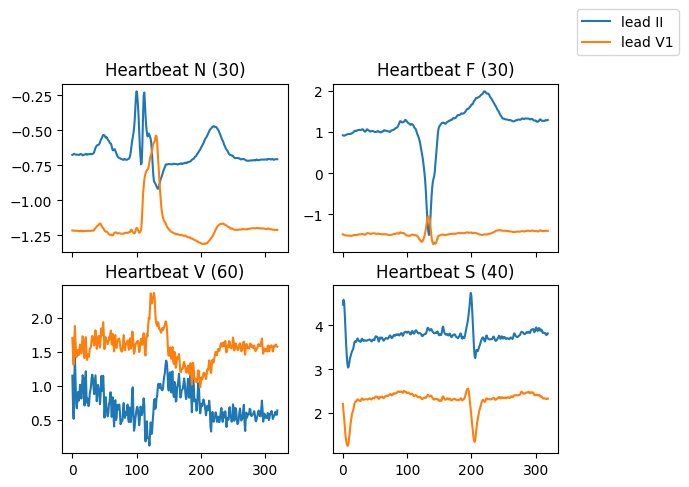

In [4]:
import matplotlib.pyplot as plt
np.unique(testY_lbl,return_counts=True)

N = np.where(testY_lbl=='N')
S = np.where(testY_lbl=='S')
F = np.where(testY_lbl=='F')
V = np.where(testY_lbl=='V')

indx_N = N[0][30]
indx_F = F[0][30]
indx_V = V[0][60]
indx_S = S[0][40]

fig, ax = plt.subplots(2, 2, sharex=True)

ax[0,0].plot(testX_1beat[indx_N][:,0], label = "lead II")
ax[0,0].plot(testX_1beat[indx_N][:,1], label = "lead V1")

fig.legend(loc='upper right', bbox_to_anchor=(1.1, 1.05))

ax[0,1].plot(testX_1beat[indx_F])
ax[1,0].plot(testX_1beat[indx_V])
ax[1,1].plot(testX_1beat[indx_S])

ax[0,0].set_title('Heartbeat N (30)')
ax[0,1].set_title('Heartbeat F (30)')
ax[1,0].set_title('Heartbeat V (60)')
ax[1,1].set_title('Heartbeat S (40)')

plt.show()

2023-06-05 09:26:33.059912: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1/1 [==============================] - 0s 440ms/step


Text(0.5, 1.0, 'Heartbeat S ')

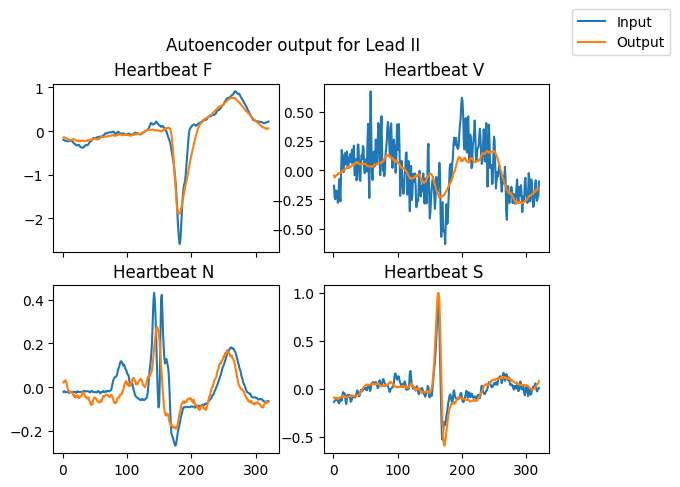

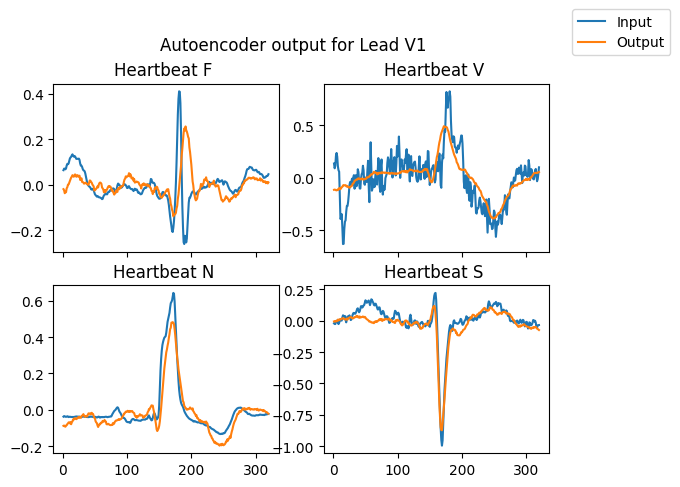

In [6]:
import keras
from keras.models import load_model

autoencoder_1beat_residual_MODEL = load_model("autoencoder_1beat_residual_MODEL")
lbls = np.unique(testY_lbl)

F_index_test = np.where(testY_lbl == lbls[0])[0].astype(int)
N_index_test = np.where(testY_lbl == lbls[1])[0].astype(int)
S_index_test = np.where(testY_lbl == lbls[2])[0].astype(int)
V_index_test = np.where(testY_lbl == lbls[3])[0].astype(int)

lbl_index_test = np.array([])

lbl_index_test = np.append(lbl_index_test,F_index_test[30])
lbl_index_test = np.append(lbl_index_test,N_index_test[30])
lbl_index_test = np.append(lbl_index_test,S_index_test[40])
lbl_index_test = np.append(lbl_index_test,V_index_test[60])

lbl_index_test = lbl_index_test.astype(int)
representations_test = autoencoder_1beat_residual_MODEL.predict(testX_1beat[lbl_index_test,:,:])
true_values_test = testX_1beat[lbl_index_test,:,:]

fig, ax = plt.subplots(2, 2, sharex=True)

ax[0,0].plot(range(1,321), true_values_test[0,:,0], label = "Input")
ax[0,0].plot(range(1,321), representations_test[0,:,0], label = "Output")
ax[1,0].plot(range(1,321), true_values_test[1,:,0])
ax[1,0].plot(range(1,321), representations_test[1,:,0])
ax[1,1].plot(range(1,321), true_values_test[2,:,0])
ax[1,1].plot(range(1,321), representations_test[2,:,0])
ax[0,1].plot(range(1,321), true_values_test[3,:,0])
ax[0,1].plot(range(1,321), representations_test[3,:,0])

fig.legend(loc='upper right', bbox_to_anchor=(1.1, 1.05))

fig.suptitle('Autoencoder output for Lead II')

ax[0,0].set_title('Heartbeat F ')
ax[0,1].set_title('Heartbeat V ')
ax[1,0].set_title('Heartbeat N ')
ax[1,1].set_title('Heartbeat S ')

fig, ax = plt.subplots(2, 2, sharex=True)

ax[0,0].plot(range(1,321), true_values_test[0,:,1], label = "Input")
ax[0,0].plot(range(1,321), representations_test[0,:,1], label = "Output")
ax[1,0].plot(range(1,321), true_values_test[1,:,1])
ax[1,0].plot(range(1,321), representations_test[1,:,1])
ax[1,1].plot(range(1,321), true_values_test[2,:,1])
ax[1,1].plot(range(1,321), representations_test[2,:,1])
ax[0,1].plot(range(1,321), true_values_test[3,:,1])
ax[0,1].plot(range(1,321), representations_test[3,:,1])

fig.legend(loc='upper right', bbox_to_anchor=(1.1, 1.05))

fig.suptitle('Autoencoder output for Lead V1')

ax[0,0].set_title('Heartbeat F ')
ax[0,1].set_title('Heartbeat V ')
ax[1,0].set_title('Heartbeat N ')
ax[1,1].set_title('Heartbeat S ')

5489/5489 [==============================] - 3s 480us/step


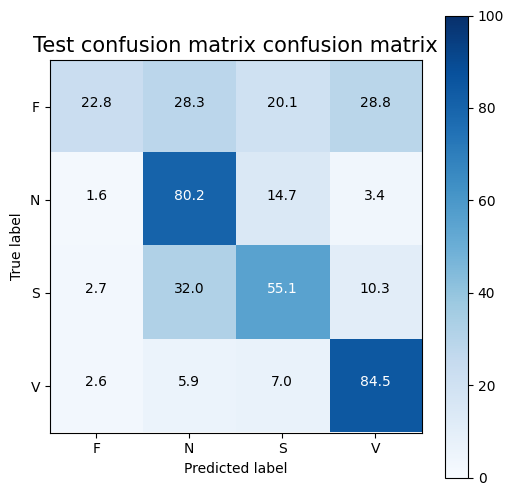

,Accuracy (%),Specificity (%),Sensit/Recall (%)
F,98.14,98.24,22.83
N,90.18,98.93,80.25
S,87.47,87.79,55.11
V,95.64,96.89,84.52


In [8]:

predicted_labels = np.empty(np.shape(testY_lbl))

#Single beat classifier
classifier_1beat = load_model("classifier_1beat_residual_MODEL")
predicted_1beat = classifier_1beat.predict(testX_1beat)
predicted_1beat = predicted_1beat.argmax(axis=-1)

#Triple beat classifier
encoder_3beat = load_model("encoder_3beat_residual_MODEL")
classifier_3beat = load_model("classifier_3beat_residual_MODEL")
feature_vector_test_3beat = encoder_3beat.predict(testX_3beat)
predicted_3beat = classifier_3beat.predict(feature_vector_test_3beat)
predicted_3beat = predicted_3beat.argmax(axis=-1) 

#Classifiers combination
for i in range(0,len(predicted_labels)):
    if predicted_1beat[i] == 3: 
        predicted_labels[i] = predicted_1beat[i]
    else:
        predicted_labels[i] = predicted_3beat[i]


 #Confusion matrix
import itertools
#plot_confusion_matrix(testY_int, predicted_labels, "Test confusion matrix", testY_lbl)
#cm = confusion_matrix(testY_int, prewdicted_labels)

plot_confusion_matrix(testY_int, predicted_labels, "Test confusion matrix", testY_lbl)
cm = confusion_matrix(testY_int, predicted_labels)
Eval = evaluation(cm)
display(Eval)

In [63]:
classifier_1beat.layers

In [22]:
#Definir la capa de GLOBAL AVERAGE POOLING 

def global_average_pooling(x):
    return K.mean(x, axis = 2)
    
def global_average_pooling_shape(input_shape):
    return input_shape[0:2]

def create_conv_autoencoder_17_7_2():
    input_sig = Input(shape = (320,2))
    
    #Encoder
    conv1 = Conv1D(150, 20, activation='selu', padding='same', kernel_initializer='glorot_uniform')(input_sig) #Convolució temporal
    norm1 = BatchNormalization()(conv1)
    pool1 = MaxPooling1D(2)(norm1)
    conv2 = Conv1D(125, 20, activation='selu', padding='same')(pool1)
    drop1 = Dropout(0.5)(conv2)
    pool2 = MaxPooling1D(2)(drop1)
    conv3 = Conv1D(100, 15, activation='selu', padding='same')(pool2)
    conv4 = Conv1D(75, 15, activation='selu', padding='same')(conv3)
    norm2 = BatchNormalization()(conv4)
    pool3 = MaxPooling1D(2)(norm2)
    conv5 = Conv1D(50, 10, activation='selu', padding='same')(pool3)
    conv6 = Conv1D(25, 10, activation='selu', padding='same')(conv5)
    drop2 = Dropout(0.5)(conv6)
    pool4 = MaxPooling1D(2)(drop2)
    conv7 = Conv1D(15, 5, activation='selu', padding='same')(pool4)
    conv8 = Conv1D(5, 5, activation='selu', padding='same')(conv7)
    flat1 = Flatten()(conv8) #transforms a 2D matrix of features into 1D for the dense layer
    inter = Dense(200, activation='selu')(flat1)
    drop3 = Dropout(0.5)(inter)
    encoded = Dense(50, activation = 'selu')(drop3)
    
    #Decoder
    decoded_inter = Dense(200, activation='selu')(encoded)
    inter2 = Dense(int(320/16*5), activation='selu')(decoded_inter)
    flat2 = Reshape((int(320/16),5))(inter2)
    conv11 = Conv1D(5, 5, activation='selu', padding='same')(flat2)
    conv12 = Conv1D(15, 5, activation='selu', padding='same')(conv11)
    up1 = UpSampling1D(2)(conv12)
    conv13 = Conv1D(25, 10, activation='selu', padding='same')(up1)
    conv14 = Conv1D(50, 10, activation='selu', padding='same')(conv13)
    up2 = UpSampling1D(2)(conv14)
    conv15 = Conv1D(75, 15, activation='selu', padding='same')(up2)
    conv16 = Conv1D(100, 15, activation='selu', padding='same')(conv15)
    up3 = UpSampling1D(2)(conv16)
    conv17 = Conv1D(125, 20, activation='selu', padding='same')(up3)
    up4 = UpSampling1D(2)(conv17)
    conv18 = Conv1D(150, 20, activation='selu', padding='same')(up4)
    decoded = Conv1D(2,360,activation = 'linear', padding = 'same')(conv18)
    
    encoder = Model(input_sig, encoded)
    autoencoder = Model(input_sig, decoded)
    opt = Adam(learning_rate = 0.0001)
    autoencoder.compile(loss='mse', optimizer = opt)
    autoencoder.save_weights('conv_autoencoder_starting_weights.h5')
    d = dict()
    d['autoencoder'] = autoencoder
    d['encoder'] = encoder
    return d

In [41]:
d = create_conv_autoencoder_17_7_2()
conv_autoencoder_17_7_2 = d['autoencoder']
conv_encoder_17_7_2 = d['encoder']
conv_autoencoder_17_7_2.load_weights('conv_autoencoder_starting_weights.h5')

In [42]:
hola = conv_autoencoder_17_7_2.layers[4].get_weights()[0]
np.shape(hola)

(20, 150, 125)

In [43]:
conv_encoder_17_7_2.layers

In [46]:
sliced_loaded_model = Sequential(conv_encoder_17_7_2.layers[:-4])

In [47]:
sliced_loaded_model.layers